In [20]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [21]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [22]:
print(tf.__version__)

2.11.0


In [23]:
tf.random.set_seed(42)
np.random.seed(42)

In [24]:
# #擁有情緒分數
train_df = pd.read_csv('data/train.csv', index_col=0)
val_df = pd.read_csv('data/val.csv', index_col=0)
test_df = pd.read_csv('data/test.csv', index_col=0)
print(train_df.shape, val_df.shape, test_df.shape)

(2132, 16) (609, 16) (305, 16)


In [25]:
train_df.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_7,SMA_14,EMA_7,EMA_14,RSI,Stoch_RSI,Upper_BB,Lower_BB,MACD,Coin_timestamp
0,0.009136,0.007458,0.009635,0.009292,0.009292,0.000018,0.008646,0.008796,0.008083,0.008515,0.230343,0.000000,0.007894,0.013228,0.364156,0.000000
1,0.009337,0.007350,0.008713,0.008152,0.008152,0.000158,0.008265,0.008548,0.007739,0.008268,0.189204,0.000000,0.008017,0.012798,0.363662,0.000469
2,0.008229,0.007002,0.008699,0.008655,0.008655,0.000319,0.008161,0.008393,0.007616,0.008134,0.291396,0.170521,0.008059,0.012603,0.363486,0.000939
3,0.008711,0.006858,0.008809,0.008293,0.008293,0.000082,0.008000,0.008203,0.007427,0.007962,0.262412,0.122158,0.008126,0.012307,0.363230,0.001408
4,0.008381,0.006480,0.007953,0.007642,0.007642,0.000137,0.007828,0.007928,0.007109,0.007711,0.179952,0.000000,0.008209,0.011764,0.362805,0.001877


In [26]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Close', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [27]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [28]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## CNN 

### Multi-step model 

In [29]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 7
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['Close'])

In [30]:
train_df.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_7,SMA_14,EMA_7,EMA_14,RSI,Stoch_RSI,Upper_BB,Lower_BB,MACD,Coin_timestamp
0,0.009136,0.007458,0.009635,0.009292,0.009292,0.000018,0.008646,0.008796,0.008083,0.008515,0.230343,0.000000,0.007894,0.013228,0.364156,0.000000
1,0.009337,0.007350,0.008713,0.008152,0.008152,0.000158,0.008265,0.008548,0.007739,0.008268,0.189204,0.000000,0.008017,0.012798,0.363662,0.000469
2,0.008229,0.007002,0.008699,0.008655,0.008655,0.000319,0.008161,0.008393,0.007616,0.008134,0.291396,0.170521,0.008059,0.012603,0.363486,0.000939
3,0.008711,0.006858,0.008809,0.008293,0.008293,0.000082,0.008000,0.008203,0.007427,0.007962,0.262412,0.122158,0.008126,0.012307,0.363230,0.001408
4,0.008381,0.006480,0.007953,0.007642,0.007642,0.000137,0.007828,0.007928,0.007109,0.007711,0.179952,0.000000,0.008209,0.011764,0.362805,0.001877


In [31]:

ms_cnn_model = Sequential([
    Conv1D(8, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(4, return_sequences=True),
    Dense(1,kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_model, multi_window)

# ms_val_performance = {}
ms_performance = {}
ms_val_performance = {}
ms_performance = {}

ms_val_performance['CNN'] = ms_cnn_model.evaluate(multi_window.val)
ms_performance['CNN'] = ms_cnn_model.evaluate(multi_window.test, verbose=0)
print(f"驗證集的MSE {ms_val_performance['CNN'][1]}")
print(f"測試集的MSE {ms_performance['CNN'][1]}")


Epoch 1/50
67/67 [==============================] - 3s 11ms/step - loss: 0.0641 - mean_absolute_error: 0.1843 - val_loss: 3.8451 - val_mean_absolute_error: 1.8069
Epoch 2/50
67/67 [==============================] - 0s 3ms/step - loss: 0.0126 - mean_absolute_error: 0.0762 - val_loss: 3.0363 - val_mean_absolute_error: 1.5683
Epoch 3/50
67/67 [==============================] - 0s 4ms/step - loss: 0.0041 - mean_absolute_error: 0.0371 - val_loss: 2.9062 - val_mean_absolute_error: 1.5252
Epoch 4/50
67/67 [==============================] - 0s 3ms/step - loss: 0.0024 - mean_absolute_error: 0.0271 - val_loss: 2.7249 - val_mean_absolute_error: 1.4687
Epoch 5/50
67/67 [==============================] - 0s 3ms/step - loss: 0.0018 - mean_absolute_error: 0.0235 - val_loss: 2.6220 - val_mean_absolute_error: 1.4349
Epoch 6/50
67/67 [==============================] - 0s 3ms/step - loss: 0.0014 - mean_absolute_error: 0.0210 - val_loss: 2.5332 - val_mean_absolute_error: 1.4072
Epoch 7/50
67/67 [=========

In [29]:
# 縮限的MSE需要調整為原本範圍
df_original = pd.read_csv('FinBERT/Data_final/BTC_final.csv')
((df_original['Close'].max()-df_original['Close'].min())*(0.24911579489707947))**0.5



129.5669550024546

In [40]:
# 縮限的MSE需要調整為原本範圍
# (df_original['Close'].max()-df_original['Close'].min())
df_original = pd.read_csv('BTC-Indicators.csv')
x=(df_original['Open'][0]-df_original['Open'].min())/(df_original['Open'].max()-df_original['Open'].min())
x

0.0026170486484541635

In [37]:
#將值縮限在0~1之間，加速訓練時間
from sklearn.preprocessing import MinMaxScaler
df_original = pd.read_csv('BTC-Indicators.csv').drop(['Date'],axis=1)
train_df=df_original
scaler = MinMaxScaler()
scaler.fit(train_df)
train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
train_df

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,SMA_7,SMA_14,EMA_7,EMA_14,RSI,Stoch_RSI,Upper_BB,Lower_BB,MACD
0,0.000000,0.002617,0.002162,0.002736,0.002664,0.002664,0.000004,0.002364,0.002357,0.002237,0.002203,0.230343,0.000000,0.002435,0.002914,0.488878
1,0.000328,0.002675,0.002130,0.002474,0.002337,0.002337,0.000033,0.002260,0.002290,0.002142,0.002139,0.189204,0.000000,0.002473,0.002820,0.488685
2,0.000657,0.002357,0.002030,0.002470,0.002481,0.002481,0.000067,0.002231,0.002249,0.002108,0.002105,0.291396,0.170521,0.002486,0.002777,0.488616
3,0.000985,0.002495,0.001988,0.002502,0.002378,0.002378,0.000017,0.002187,0.002198,0.002055,0.002060,0.262412,0.122158,0.002507,0.002711,0.488516
4,0.001314,0.002401,0.001878,0.002259,0.002191,0.002191,0.000029,0.002140,0.002124,0.001967,0.001995,0.179952,0.000000,0.002532,0.002592,0.488350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3041,0.998686,0.352800,0.348392,0.344893,0.341601,0.341601,0.076377,0.367799,0.365918,0.366877,0.368212,0.593241,0.844457,0.365763,0.354986,0.544335
3042,0.999015,0.341729,0.335363,0.342695,0.341263,0.341263,0.045858,0.364592,0.367379,0.364123,0.367140,0.577809,0.803424,0.365862,0.355243,0.535756
3043,0.999343,0.341343,0.341840,0.346058,0.346988,0.346988,0.047407,0.362915,0.369365,0.363554,0.367018,0.608291,0.856062,0.366302,0.356090,0.531486
3044,0.999672,0.347092,0.344807,0.347896,0.346419,0.346419,0.064549,0.360058,0.371286,0.362978,0.366832,0.603631,0.831206,0.366518,0.356277,0.527364


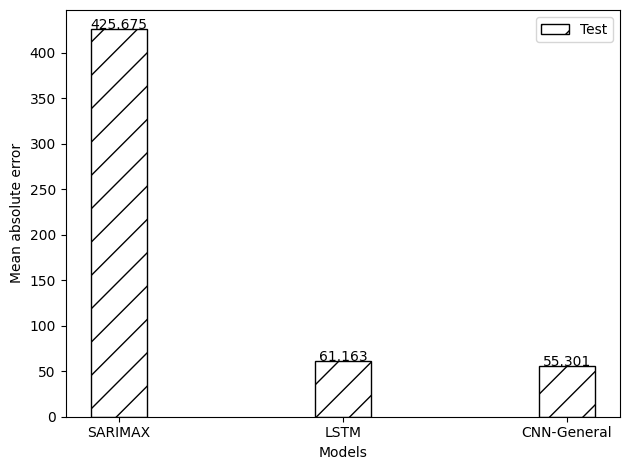

In [4]:
ms_mae_test=[425.67469182453505,61.16331362602122,55.30109908562742]

x = np.arange(len(ms_mae_test))
labels = [ 'SARIMAX','LSTM','CNN-General']

plt.bar(x,ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')

for i in x:
    plt.text(x=i, y=ms_mae_test[i]+ 0.45, s=str(round(ms_mae_test[i], 3)), ha='center')



plt.xlabel('Models')
plt.ylabel('Mean absolute error')
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('peixeiro.png', dpi=300)